The goal of this project is to explore, segment, and cluster the neighborhoods of the city of Toronto and use the data found from these neighbouhoods to determine if there is a correlation between high crime rate in low income in any of these neighbourhoods.

For the Toronto neighborhood data, a Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M exists that has all the information needed to explore and cluter the neighbourhoods. The first step is to scrape the data from the webpage then format it into a pandas datafram structure for analysis and clustering. 

First we need to load all libraries and dependencies. 

In [1]:

import lxml
from bs4 import BeautifulSoup
import folium  # map rendering library
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.colors as colors
import matplotlib.cm as cm
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
import requests  # library to handle requests
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import json  # library to handle JSON files
import pandas as pd  # library for data analsysis
import numpy as np  # library to handle data in a vectorized manner

from matplotlib import pyplot as plt
print('Importing Libraries')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('.')
print('.')
# Matplotlib and associated plotting modules
# import k-means from clustering stage
print('.')
print('Done')


Importing Libraries
.
.
.
Done


Then we need to use our webscraper (BeautifulSoup is what we chose) to take the data from the webpage and insert it into our newly created data structure.

In [2]:
# downloads and parses data (uses older version of wiki page for proper formatting)
r = requests.get(
    'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=876823784', timeout=5.00)
soup = BeautifulSoup(r.text, 'html.parser')
table = soup.find('table', attrs={'class': 'wikitable sortable'})

# retrieves page headers
headers = table.find_all('th')
for i, head in enumerate(headers):
    headers[i] = str(headers[i]).replace(
        "<th>", "").replace("</th>", "").replace("\n", "")


# finds all elements and skips first in table
rows = table.find_all('tr')
rows = rows[1:len(rows)]

# used to skip meta symbols and line feeds between rows
for i, row in enumerate(rows):
    rows[i] = str(rows[i]).replace(
        "\n</td></tr>", "").replace("<tr>\n<td>", "")

# creates dataframe, expands rows, and drops old row
df = pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n=2, expand=True)
df.drop(columns=[0], inplace=True)

# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)

# give "Not assigned" neighbourhoods same name as Borough:
df.Neighbourhood.replace("Not assigned", np.nan, inplace=True)


# copy Borough value to neighbourhood if NaN:
df.Neighbourhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df = df.drop_duplicates()

# extract titles from columns
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)', expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)', expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto", ""))
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)", ""))

# combine multiple neighbourhoods with the same post code
df2 = pd.DataFrame({'Postcode': df.Postcode.unique()})
df2['Borough'] = pd.DataFrame(list(set(
    df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['neighbourhood'] = pd.Series(list(set(
    df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['neighbourhood'] = df2['neighbourhood'].apply(lambda x: ', '.join(x))
df2.dtypes

df2.head()


C:\Users\16bre\AppData\Local\Temp/ipykernel_13988/1748872032.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Neighbourhood.loc[


,Postcode,Borough,neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront , Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park (Toronto),Queen's Park


Now that we have the data from the wikipedia page in a structured format we can pull some geospatial data from a seperate file (TO_geospatial_data.csv) to collect latitude and longitute coordinate data.

In [3]:
# add Geo-spatial data
dfll = pd.read_csv("TO_geospatial_data.csv")
dfll.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df.set_index("Postcode")
toronto_data = pd.merge(df, dfll)
toronto_data2 = pd.merge(df2, dfll)
toronto_data.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


Now we can add further data to the dataframe through Neighbourhood_Crime_Rates_Boundary_File_.csv. This will then merge with our previous dataframe to give us a list of all neighbourhoods with coordinates and crime data attached.

In [4]:
dfcr = pd.read_csv("Neighbourhood_Crime_Rates_Boundary_File_.csv")
dfcr.set_index("Neighbourhood")
toronto_data.set_index("Neighbourhood")
toronto_data = pd.merge(toronto_data, dfcr)
toronto_data.drop(['OBJECTID', 'Hood_ID'], axis=1, inplace=True)
toronto_data.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,118,138,133,83,112,132,119.3,0.18,753.9,20,14,20,14,13,18,16.5,0.38,102.8,38,46,23,32,35,60,39.0,0.71,342.7,0,0,2,1,0,1,0.7,1.00,5.7,10,18,13,10,14,14,13.2,0.00,80.0,6,6,4,5,4,5,5.0,0.25,28.6,4.755219e+06,11800.341701
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,10803,98,83,97,110,123,156,111.2,0.27,1444.0,8,11,3,7,9,21,9.8,1.33,194.4,30,30,25,29,27,65,34.3,1.41,601.7,1,0,1,3,2,1,1.3,-0.50,9.3,20,14,12,14,20,14,15.7,-0.30,129.6,8,4,2,2,5,5,4.3,0.00,46.3,6.502953e+05,3258.967627
2,M1B,"Scarborough, Toronto",Rouge,43.806686,-79.194353,46496,177,167,145,185,184,182,173.3,-0.01,391.4,57,50,21,33,55,87,50.5,0.58,187.1,75,73,75,71,81,59,72.3,-0.27,126.9,1,0,0,4,0,0,0.8,0.00,0.0,24,37,31,42,28,32,32.3,0.14,68.8,10,8,13,11,16,13,11.8,-0.19,28.0,3.753449e+07,36133.559843
3,M1B,"Scarborough, Toronto",Malvern,43.806686,-79.194353,43794,215,280,280,289,272,333,278.2,0.22,760.4,25,31,36,56,64,71,47.2,0.11,162.1,63,43,65,35,64,44,52.3,-0.31,100.5,0,0,4,2,3,1,1.7,-0.67,2.3,40,45,64,64,45,46,50.7,0.02,105.0,10,3,8,7,16,10,9.0,-0.38,22.8,8.866244e+06,12081.208643
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,128,147,153,122,145,152,141.2,0.05,693.0,8,7,4,12,8,8,7.8,0.00,36.5,50,20,14,12,14,16,21.0,0.14,72.9,1,0,0,0,0,0,0.2,0.00,0.0,25,22,24,20,16,13,20.0,-0.19,59.3,9,3,3,4,1,3,3.8,2.00,13.7,2.473306e+06,8487.752111


We can then perform the exact same operations to concatenate income data into the same dataframe.

In [5]:
dfin = pd.read_csv("wellbeing_toronto_incomedata.csv")
dfin.set_index("Neighbourhood")
dfin.drop('Neighbourhood Id', axis=1, inplace=True)
toronto_data = pd.merge(toronto_data, dfin)
toronto_data.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,Average Family Income
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,118,138,133,83,112,132,119.3,0.18,753.9,20,14,20,14,13,18,16.5,0.38,102.8,38,46,23,32,35,60,39.0,0.71,342.7,0,0,2,1,0,1,0.7,1.00,5.7,10,18,13,10,14,14,13.2,0.00,80.0,6,6,4,5,4,5,5.0,0.25,28.6,4.755219e+06,11800.341701,65104.0
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,10803,98,83,97,110,123,156,111.2,0.27,1444.0,8,11,3,7,9,21,9.8,1.33,194.4,30,30,25,29,27,65,34.3,1.41,601.7,1,0,1,3,2,1,1.3,-0.50,9.3,20,14,12,14,20,14,15.7,-0.30,129.6,8,4,2,2,5,5,4.3,0.00,46.3,6.502953e+05,3258.967627,51758.0
2,M1B,"Scarborough, Toronto",Rouge,43.806686,-79.194353,46496,177,167,145,185,184,182,173.3,-0.01,391.4,57,50,21,33,55,87,50.5,0.58,187.1,75,73,75,71,81,59,72.3,-0.27,126.9,1,0,0,4,0,0,0.8,0.00,0.0,24,37,31,42,28,32,32.3,0.14,68.8,10,8,13,11,16,13,11.8,-0.19,28.0,3.753449e+07,36133.559843,86997.0
3,M1B,"Scarborough, Toronto",Malvern,43.806686,-79.194353,43794,215,280,280,289,272,333,278.2,0.22,760.4,25,31,36,56,64,71,47.2,0.11,162.1,63,43,65,35,64,44,52.3,-0.31,100.5,0,0,4,2,3,1,1.7,-0.67,2.3,40,45,64,64,45,46,50.7,0.02,105.0,10,3,8,7,16,10,9.0,-0.38,22.8,8.866244e+06,12081.208643,64497.0
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,128,147,153,122,145,152,141.2,0.05,693.0,8,7,4,12,8,8,7.8,0.00,36.5,50,20,14,12,14,16,21.0,0.14,72.9,1,0,0,0,0,0,0.2,0.00,0.0,25,22,24,20,16,13,20.0,-0.19,59.3,9,3,3,4,1,3,3.8,2.00,13.7,2.473306e+06,8487.752111,55824.0


We then remove the annual number of crimes reported for the various crimes, since we're only considering the averages to calculate the crime rate per neighbourhood

In [6]:
toronto_data.drop(toronto_data.loc[:, 'Assault_2014':'Assault_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'Assault_CHG':'Assault_Rate_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'AutoTheft_2014':'AutoTheft_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'AutoTheft_CHG':'AutoTheft_Rate_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'BreakandEnter_2014':'BreakandEnter_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'BreakandEnter_CHG':'BreakandEnter_Rate_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'Homicide_2014':'Homicide_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'Homicide_CHG':'Homicide_Rate_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'Robbery_2014':'Robbery_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'Robbery_CHG':'Robbery_Rate_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'TheftOver_2014':'TheftOver_2019'], axis=1, inplace=True)
toronto_data.drop(toronto_data.loc[:, 'TheftOver_CHG':'TheftOver_Rate_2019'], axis=1, inplace=True)


toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length,Average Family Income
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,4.755219e+06,11800.341701,65104.0
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,10803,111.2,9.8,34.3,1.3,15.7,4.3,6.502953e+05,3258.967627,51758.0
2,M1B,"Scarborough, Toronto",Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,3.753449e+07,36133.559843,86997.0
3,M1B,"Scarborough, Toronto",Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,8.866244e+06,12081.208643,64497.0
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,2.473306e+06,8487.752111,55824.0


We then use this formula to calculate a unified crime rate for a given neighborhood.

In [7]:
toronto_data['Totoal_Crime_AVG'] = (toronto_data['Assault_AVG'] + toronto_data['AutoTheft_AVG'] + toronto_data['BreakandEnter_AVG'] + toronto_data['Homicide_AVG'] + toronto_data['Robbery_AVG'] + toronto_data['TheftOver_AVG'])/6
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length,Average Family Income,Totoal_Crime_AVG
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,4.755219e+06,11800.341701,65104.0,32.283333
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,10803,111.2,9.8,34.3,1.3,15.7,4.3,6.502953e+05,3258.967627,51758.0,29.433333
2,M1B,"Scarborough, Toronto",Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,3.753449e+07,36133.559843,86997.0,56.833333
3,M1B,"Scarborough, Toronto",Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,8.866244e+06,12081.208643,64497.0,73.183333
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,2.473306e+06,8487.752111,55824.0,32.333333


Plotting raw data...

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length,Average Family Income,Totoal_Crime_AVG
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,4.755219e+06,11800.341701,65104.0,32.283333
1,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,10803,111.2,9.8,34.3,1.3,15.7,4.3,6.502953e+05,3258.967627,51758.0,29.433333
2,M1B,"Scarborough, Toronto",Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,3.753449e+07,36133.559843,86997.0,56.833333
3,M1B,"Scarborough, Toronto",Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,8.866244e+06,12081.208643,64497.0,73.183333
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,2.473306e+06,8487.752111,55824.0,32.333333


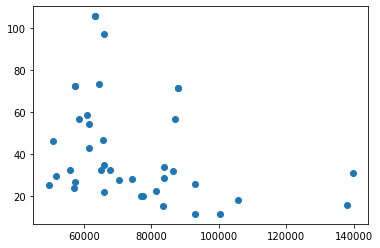

In [8]:
plt.scatter(toronto_data['Average Family Income'], toronto_data['Totoal_Crime_AVG'])
toronto_data.head()

C:\Users\16bre\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


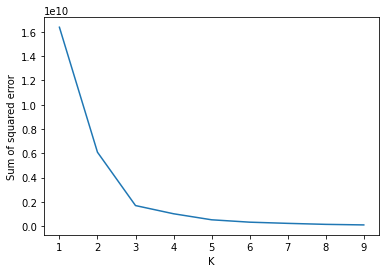

In [9]:
#Using elbow method to find optimal value of K

sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(toronto_data[['Average Family Income','Totoal_Crime_AVG']])
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

Plotting data with K Means clustering algorithm...

No handles with labels found to put in legend.


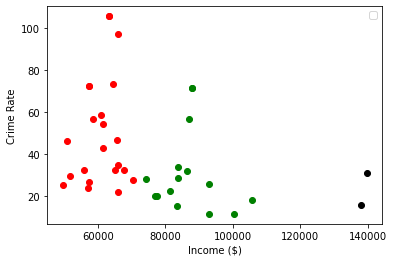

In [10]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(toronto_data[['Totoal_Crime_AVG','Average Family Income']])
toronto_data['cluster']=y_predicted

df1 = toronto_data[toronto_data.cluster==0]
df2 = toronto_data[toronto_data.cluster==1]
df3 = toronto_data[toronto_data.cluster==2]
plt.scatter(df1['Average Family Income'],df1['Totoal_Crime_AVG'],color='green')
plt.scatter(df2['Average Family Income'],df2['Totoal_Crime_AVG'],color='red')
plt.scatter(df3['Average Family Income'],df3['Totoal_Crime_AVG'],color='black')
plt.xlabel('Income ($)')
plt.ylabel('Crime Rate')
plt.legend()

Defines variables to be used in folium.

In [11]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates for Toronto ON are latitude: {}, longitute: {}.'.format(
    latitude, longitude))


The geographical coordinates for Toronto ON are latitude: 43.6534817, longitute: -79.3839347.


We can now implement folium to create a map with datapoints at each of the toronto neighbourhoods we have in our dataframe.

In [12]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(toronto_data2['Latitude'], toronto_data2['Longitude'], toronto_data2['Borough'], toronto_data2['neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto


Now its time to implement the foursquare API we start by passing our program our Foursquare ID and SECRET.

In [13]:
CLIENT_ID = 'GA5LNQMSFSRYYWKSU3FX4ITIVOFNSXXACIHKE3PAHSYI3DNB'  # your Foursquare ID
# your Foursquare Secret
CLIENT_SECRET = 'L5LANNQCJRFDJK3A5PZ0ETSFTLSROJBCPUXQII4YFBHPUNK1'
VERSION = '20220411'  # Foursquare API version

print('Foursquare API Credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Foursquare API Credentials:
CLIENT_ID: GA5LNQMSFSRYYWKSU3FX4ITIVOFNSXXACIHKE3PAHSYI3DNB
CLIENT_SECRET:L5LANNQCJRFDJK3A5PZ0ETSFTLSROJBCPUXQII4YFBHPUNK1


We then print out the neighbourhood in the first row of our dataframe for reference...

In [14]:
toronto_data2.loc[0, 'neighbourhood']


'Parkwoods'

...as well as setting the latitude and longitute of this first neighbourhood into variables we will pass in the API call.

In [15]:
# neighbourhood latitude value
neighbourhood_latitude = toronto_data2.loc[0, 'Latitude']
# neighbourhood longitude value
neighbourhood_longitude = toronto_data2.loc[0, 'Longitude']

neighbourhood_name = toronto_data2.loc[0, 'neighbourhood']  # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name,
                                                               neighbourhood_latitude,
                                                               neighbourhood_longitude))


Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


Now we call foursquare API and we recieve a large amount of data to put into a new dataframe.

In [16]:
url = "https://api.foursquare.com/v3/places/search"

PARAMS = {
    'll': (str(neighbourhood_latitude) + "," + str(neighbourhood_longitude)),
    'radius': 500,  # define radius
    'limit': 10  # limit of number of venues returned by Foursquare API
}

headers = {
    "Accept": "application/json",
    "Authorization": "fsq39l+XALKKrY9mbD/OXqED/cnk6KMe3P106YFn/CeTK9o="
}

response = requests.request("GET", url, headers=headers, params=PARAMS)
results = response.json()
df3 = pd.json_normalize(results['results'])

print(df3)




                     fsq_id  \
0  4e8d9dcdd5fbbbb6b3003c7b   
1  58f01a208f2c1a558cea5f7d   
2  4cb11e2075ebb60cd1c4caad   

                                          categories chains  distance  \
0  [{'id': 16032, 'name': 'Park', 'icon': {'prefi...     []       245   
1  [{'id': 11098, 'name': 'Roofer', 'icon': {'pre...     []       301   
2  [{'id': 17057, 'name': 'Food and Beverage Reta...     []       312   

                                  link             name         timezone  \
0  /v3/places/4e8d9dcdd5fbbbb6b3003c7b  Brookbanks Park  America/Toronto   
1  /v3/places/58f01a208f2c1a558cea5f7d         Sun Life  America/Toronto   
2  /v3/places/4cb11e2075ebb60cd1c4caad    Variety Store  America/Toronto   

   geocodes.main.latitude  geocodes.main.longitude  geocodes.roof.latitude  \
0               43.754751               -79.328439               43.754751   
1               43.754732               -79.332606               43.754732   
2               43.751978               -79